In [1]:
%matplotlib inline
import torch
import torchvision
import json
import cv2
import numpy as np
import os

from matplotlib import pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter 
from torchvision import transforms, utils
from torchsummary import summary

from Data_Loader import Pose_Dataset, my_collate, RandomFlip, RandomRotate, ToTensor
from model import VRUNet
from Modify_annotations import scale_annotations

In [2]:
annotations_path = 'Data/annotations/COCO/person_keypoints_train2017.json'
img_path = 'D:/Downloads/train2017/train2017/'

val_annotations_path = 'Data/annotations/COCO/person_keypoints_val2017.json'
val_img_path = 'D:/Downloads/val2017/val2017/'

In [3]:
torch.cuda.empty_cache()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
val_dataset = Pose_Dataset(annotations_path = val_annotations_path,
                           img_path = val_img_path,
                           transform = transforms.Compose([
                               RandomFlip(0.5),
                               RandomRotate(degree = 10),
                               ToTensor()
                           ]),
                           dataset = 'COCO'
                          )
val_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle = True, collate_fn = my_collate)

In [62]:
iterator = iter(val_dataloader)
image, target = next(iterator)

torch.Size([1, 3, 185, 81]) torch.Size([1, 68, 185, 81])


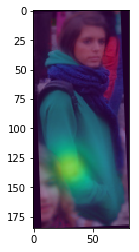

In [107]:
print(image.shape, target.shape)
img = np.transpose(image[0].cpu(), (1,2,0))
plt.imshow(img[:, :, [2,1,0]])
plt.imshow(target[0][8].cpu(), alpha = 0.5)
plt.show()

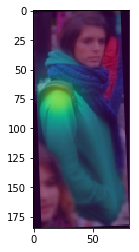

In [81]:
weights = (target[0][6] >=0.01)
trgt = target[0][6]*weights
plt.imshow(trgt.cpu())
plt.imshow(img[:, :, [2,1,0]], alpha = 0.5)

In [83]:
model = VRUNet().to(device)
model.eval()

VRUNet(
  (Backbone): BackBone(
    (bb1): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (1): Conv(
        (conv): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (2): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (3): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
    )
    (bb2): Seque

In [84]:
pred = model(image)
print(pred.shape)

torch.Size([1, 68, 185, 81])


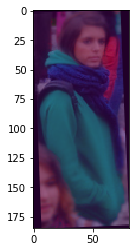

In [85]:
plt.imshow(img[:, :, [2,1,0]])
plt.imshow(pred[0][0].detach().cpu(), alpha = 0.5)
plt.show()

In [86]:
model.load_state_dict(torch.load('trained_models/first_model_2.pth'))
model.eval()

VRUNet(
  (Backbone): BackBone(
    (bb1): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (1): Conv(
        (conv): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (2): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (3): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
    )
    (bb2): Seque

In [87]:
pred = model(image)
print(pred.shape)

torch.Size([1, 68, 185, 81])


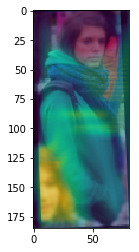

In [112]:
plt.imshow(img[:, :, [2,1,0]])
plt.imshow(pred[0][42].detach().cpu(), alpha = 0.5)
plt.show()